# Quantum Variational Circuit
This is a variation of the notebook `qvc_haar_obs.ipynb`, but in this work we use not the observables of a quantum state but we try to load the state in the quantum circuit and we then use a VQC to try and classify separable and entangled states.

In [2]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

## Dataset
The dataset is is composed by the 16 cell of a 4x4 unitary matrix where the last column reppresent if the state generated from appling the unitary matrix to the state $| 00 \rangle$ is separable or entangled.

In [3]:
# Number of total exemples 
n_exemples = 2000

# Loading dataset with pandas
dataset = pd.read_csv('../datasets/ds_haar_op.csv')
dataset = dataset[:n_exemples]

In [4]:
# Dividing dataset in features and label
X = dataset.to_numpy(dtype=np.csingle)[:,0:16]
y = dataset.to_numpy()[:,-1]

# Redifining labels on -1,1
y = np.array(2 * (y - 0.5),dtype=int)

In [5]:
# Spliting dataset in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8)
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 1600
Test size: 400


In [6]:
# Setting the number of qbits the same as the number of features
n_qubits = 4
print("Number of Qbits: ",n_qubits)

Number of Qbits:  4


## Quantum Circuit

The circuit is composed of 4 qbit, we apply a unitary matrix to the first two qbit and the same matrix to the last two. We then apply a Strongly Entangled Layer which is a template found in pennylane composed of rotation and cnot.
The image below is only representative of the circuit as the real number of layers for the QVC is different from 1. It's set to 1 only to make the circuit more readable. 

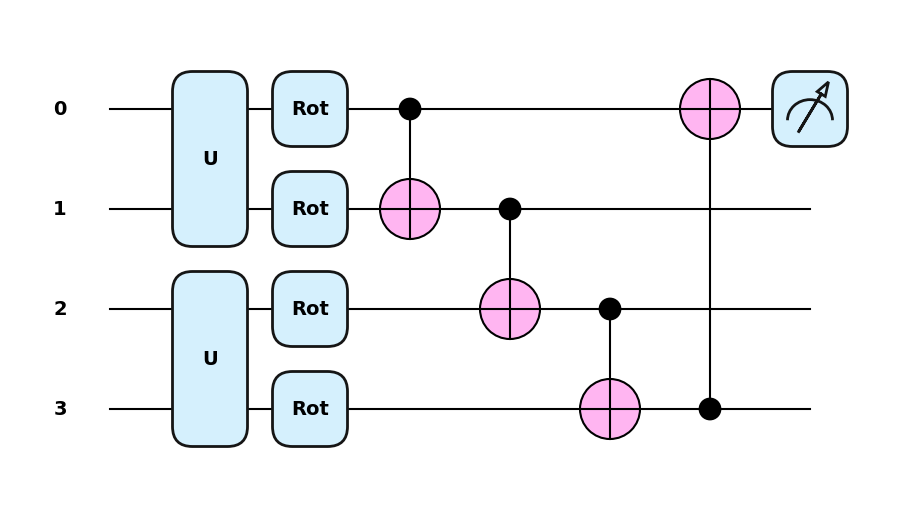

In [12]:
dev_var = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev_var, diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    qml.QubitUnitary(x.reshape(4,4),wires=[0,1])
    qml.QubitUnitary(x.reshape(4,4),wires=[2,3])

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# Exemple of the circuit
fig, ax = qml.draw_mpl(quantum_model,expansion_strategy="device",style="pennylane")(X_test[0],np.random.randn(1, n_qubits,3))

## Functions

In [10]:
def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""

    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

## Training and test

step 0 , loss 0.936921320707136
step 10 , loss 0.9809507358869439
step 20 , loss 1.0451454733037626
step 30 , loss 0.8473840185820201
step 40 , loss 0.8605829577678868
step 50 , loss 0.8637048958882607
step 60 , loss 1.0363614640991028
step 70 , loss 0.9666970451827757
step 80 , loss 1.0131703288414216
step 90 , loss 0.9675315574559413
accuracy on test set: 0.5775


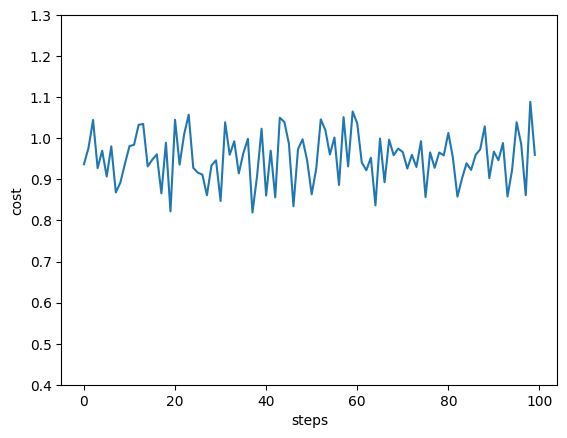

In [22]:
n_layers = 6
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0.4, 1.3))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

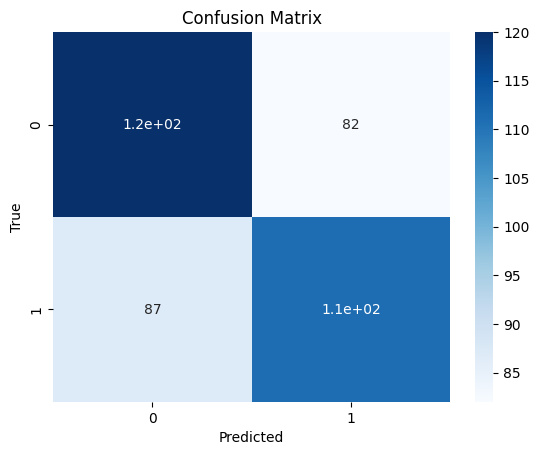

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, pred_test)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()